<a href="https://colab.research.google.com/github/stevengregori92/TransferLearning/blob/main/Transfer_Learning_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "jcopdl<2.0"
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17926 sha256=e9355b02739bd5fef7c106244428c2d97c5234a8bb0bdd8fe945719de82d2176
  Stored in directory: /root/.cache/pip/wheels/bb/e9/63/3299b93a452f4225cffbb9bc9904fedbbc17bb03d31f16a9fe
Successfully built jcopdl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1IKhuv54e3YkxYT8XvC5od_dWZXARHmEO

Downloading...
From: https://drive.google.com/uc?id=1IKhuv54e3YkxYT8XvC5od_dWZXARHmEO
To: /content/paranoma.zip
100% 25.7M/25.7M [00:00<00:00, 124MB/s]


In [ ]:
!unzip /content/paranoma.zip

Archive:  /content/paranoma.zip
   creating: data/
  inflating: data/test_label.csv     
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/1409.jpg      
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._1409.jpg  
  inflating: data/test/1347.jpg      
  inflating: __MACOSX/data/test/._1347.jpg  
  inflating: data/test/1145.jpg      
  inflating: __MACOSX/data/test/._1145.jpg  
  inflating: data/test/360.jpg       
  inflating: __MACOSX/data/test/._360.jpg  
  inflating: data/test/1192.jpg      
  inflating: __MACOSX/data/test/._1192.jpg  
  inflating: data/test/374.jpg       
  inflating: __MACOSX/data/test/._374.jpg  
  inflating: data/test/1964.jpg      
  inflating: __MACOSX/data/test/._1964.jpg  
  inflating: data/test/1958.jpg      
  inflating: __MACOSX/data/test/._1958.jpg  
  inflating: data/test/572.jpg       
  inflating: __MACOSX/da

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#Dataset & Dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [ ]:
bs=64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_set = MultilabelDataset('data/train_label.csv', 'data/train/', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=4)

test_set = MultilabelDataset('data/test_label.csv', 'data/test/', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle = True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

#Arsitektur & Config

Contoh cara memakai Pretrained-Modoel

In [ ]:
from torchvision.models import mobilenet_v2

mnet = mobilenet_v2(pretrained=True)

for param in mnet.parameters():
  param.requires_grad = False

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 76.3MB/s]


In [ ]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [ ]:
class CustomMobilenetV2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()
    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, 5),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.mnet(x)

  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

In [ ]:
config = set_config({
    'output_size': len(train_set.classes),
    'batch_size': bs,
    'crop_size': crop_size
})

##Phase 1: Adaptation(lr standard + patience kecil)

In [ ]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost/len(dataset)
    return cost

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4917 | Test_cost  = 0.3769 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3415 | Test_cost  = 0.3044 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2935 | Test_cost  = 0.2786 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2738 | Test_cost  = 0.2548 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2518 | Test_cost  = 0.2477 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2442 | Test_cost  = 0.2494 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2477


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2273 | Test_cost  = 0.2288 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2347 | Test_cost  = 0.2202 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fef23605af0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fef23605af0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.2247 | Test_cost  = 0.2351 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2202


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2152 | Test_cost  = 0.2259 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2202
==> Execute Early Stopping at epoch: 10 | Best test_cost: 0.2202
==> Best model is saved at model


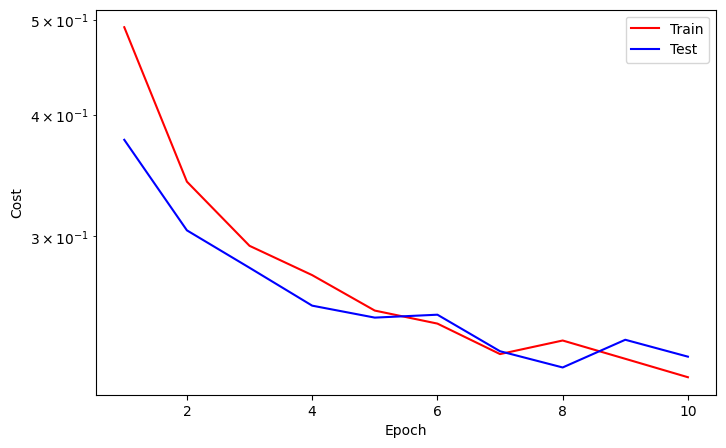

In [ ]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

##Phase 2: Fine-tuning (lr kecil, patience tambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback.reset_early_stop()
callback.early_stop_patience=5

In [29]:
while True:
  train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_cost'):
    callback.plot_cost()
    break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train:   0%|          | 0/26 [00:00<?, ?it/s]

RuntimeError: ignored

#Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0

#Sanity Check

In [ ]:
def convert_to_label(x):
  return [label for pred, label in zip(x, label2cat) if pred == 1]

def inverse_norm(img):
  img[0, :, :] = img[0, :, :]* 0.229 + 0.485
  img[1, :, :] = img[1, :, :]* 0.224 + 0.456
  img[2, :, :] = img[2, :, :]* 0.225 + 0.406
  return img

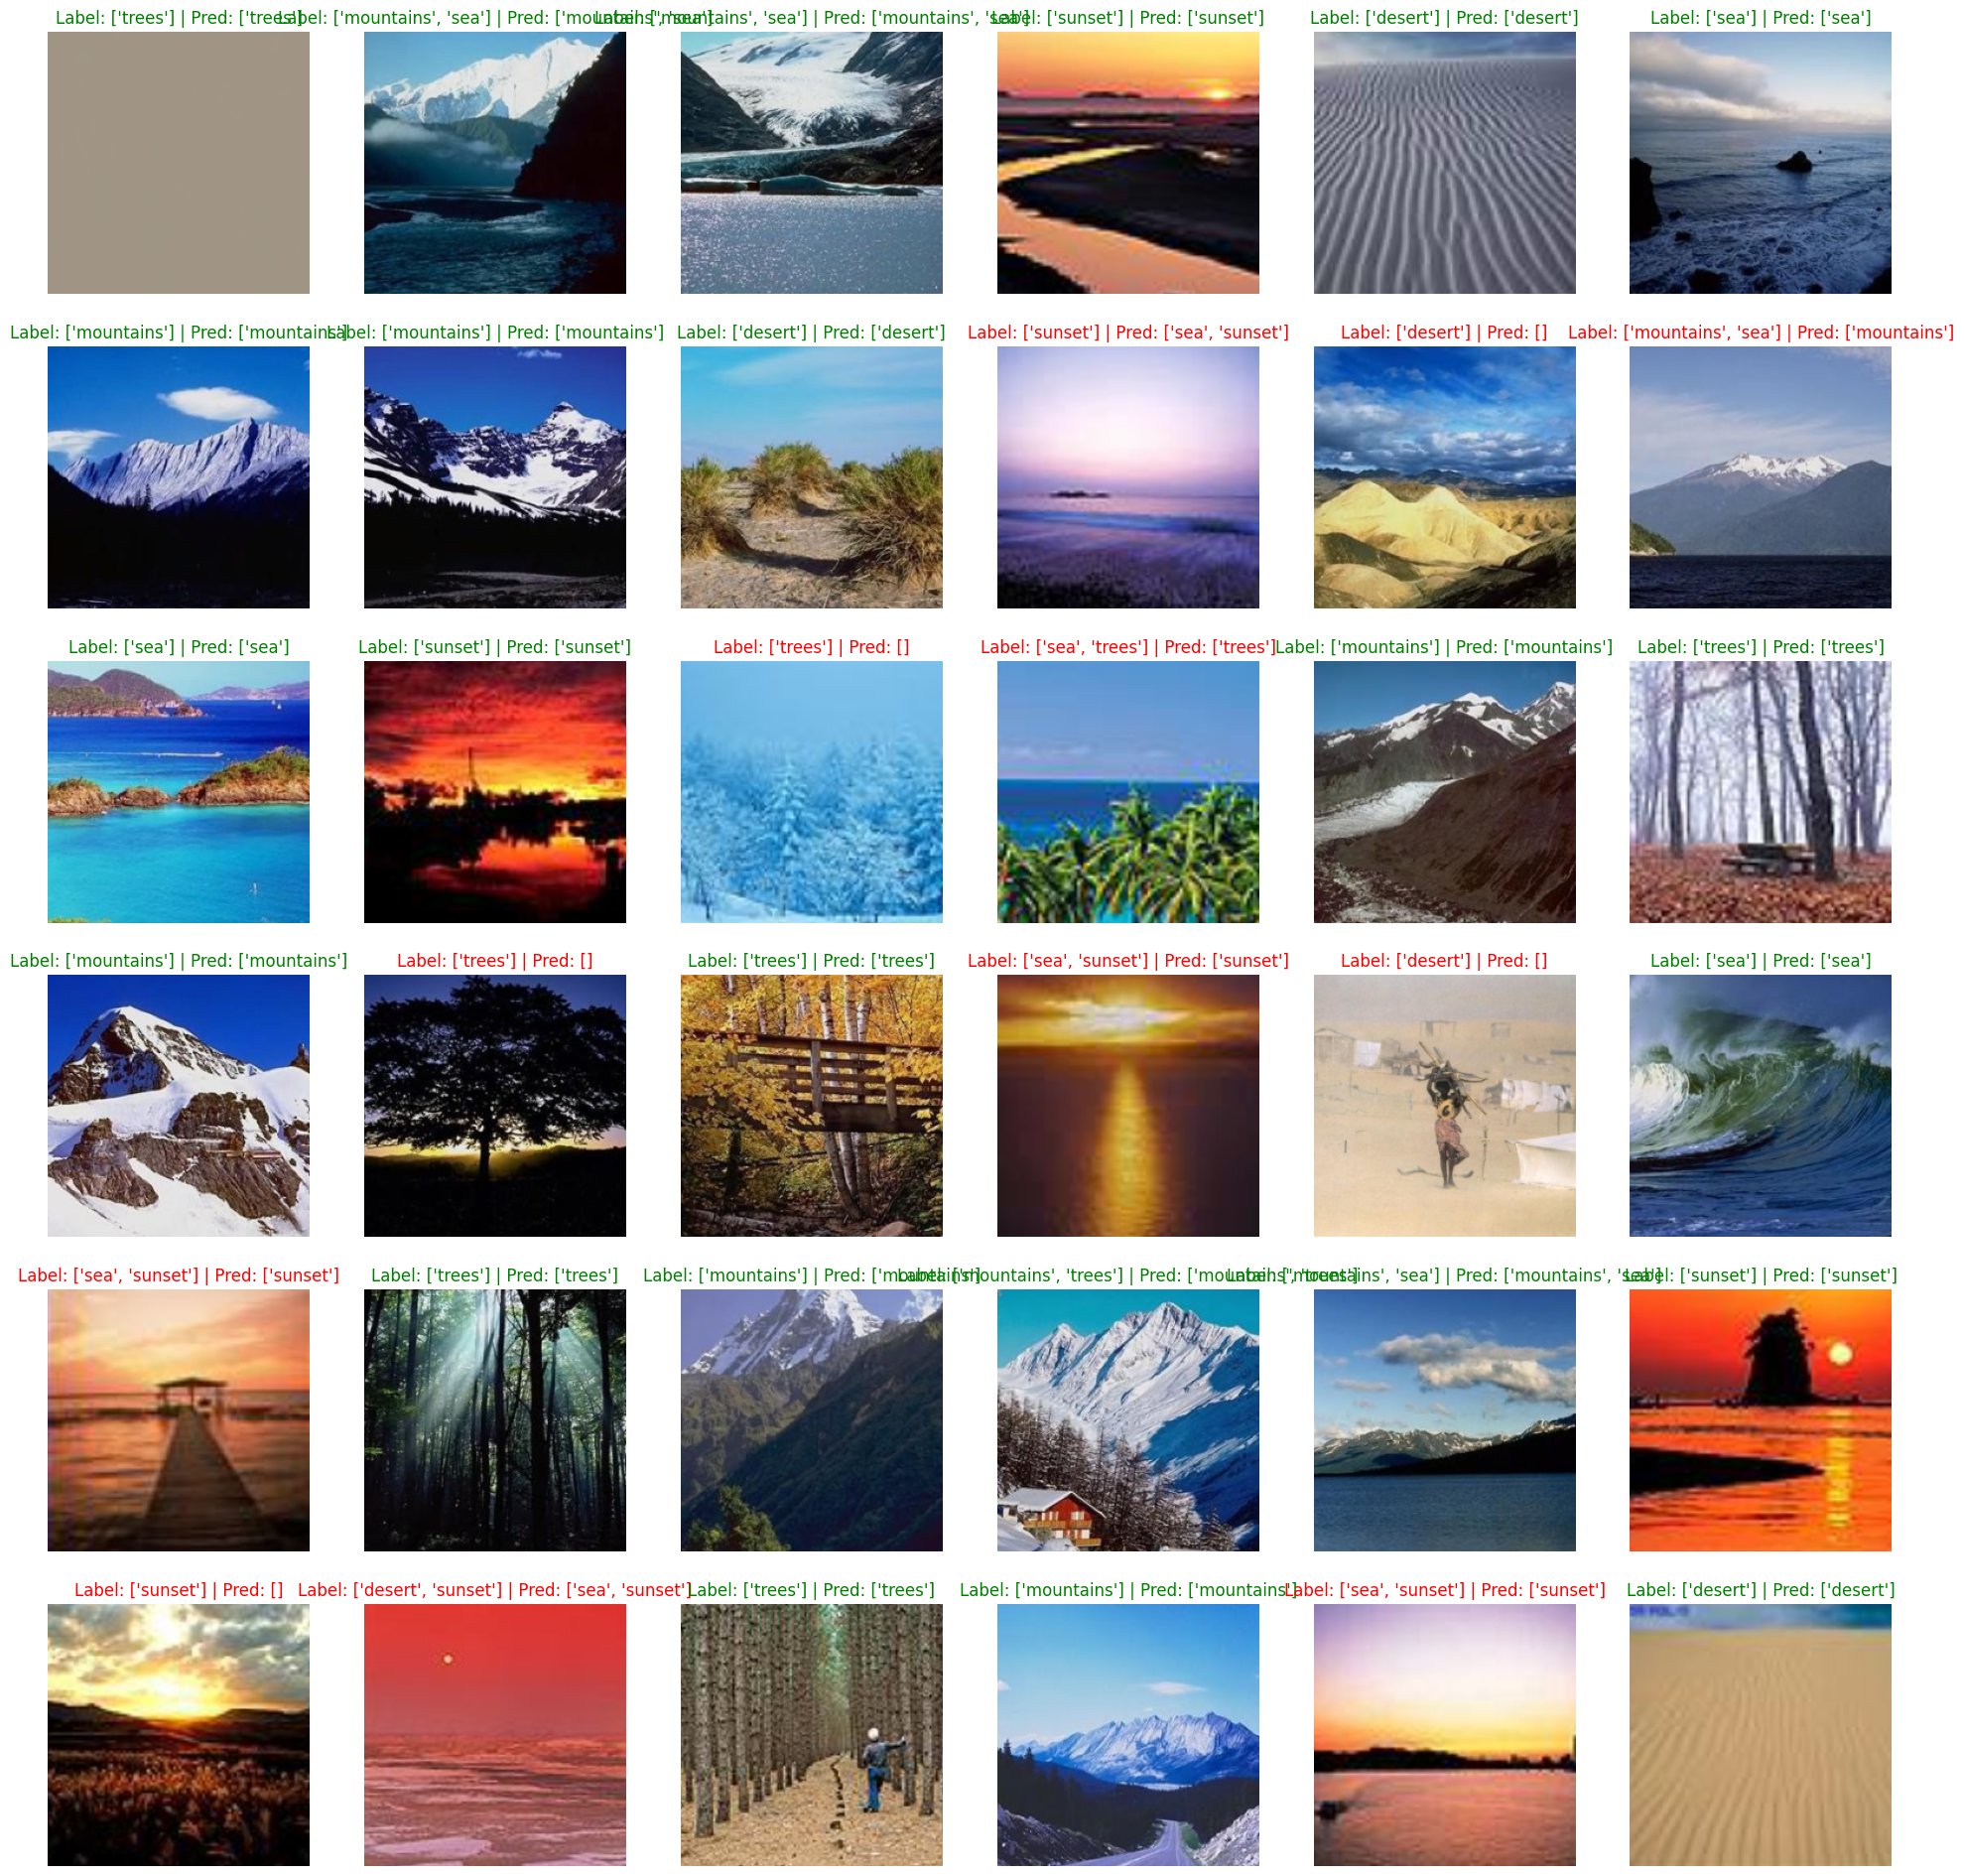

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
  font={'color': 'r'} if (pred != label).any() else {'color': 'g'}
  label, pred = convert_to_label(label), convert_to_label(pred)
  ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font);
  ax.axis('off');